    n  Experimental_ms  Theory_nlogn  Scaled_nlogn
   16         0.316375     44.361420      0.012163
   32         0.128458    110.903549      0.030409
   64         0.221708    266.168517      0.072980
  128         0.462792    621.059874      0.170288
  256         1.065542   1419.565426      0.389229
  512         1.974791   3194.022208      0.875766
 1024         3.755791   7097.827129      1.946146
 2048         7.542583  15615.219684      4.281521
 4096        13.214583  34069.570219      9.341500
 8192        23.513416  73817.402141     20.239917
16384        48.015917 158991.327688     43.593667
32768        97.757917 340695.702189     93.415000
65536       199.285333 726817.498003    199.285333

Normalization constant C (matches largest n): 2.741890e-04
Saved: ./hull_runtime_vs_nlogn.csv
Saved: ./hull_exp_vs_nlogn_loglog.png
Saved: ./hull_straight_line.png
Saved: ./hull_points_overlay.png


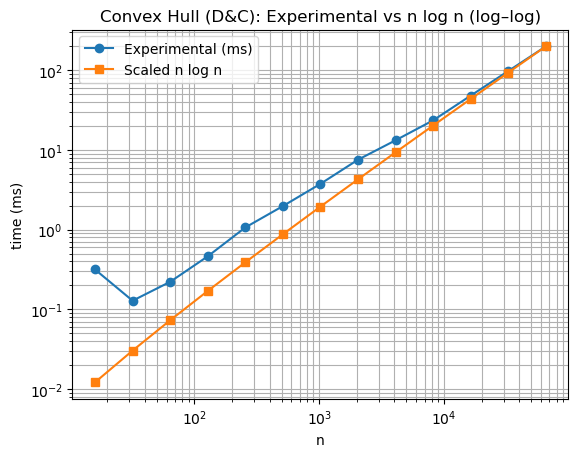

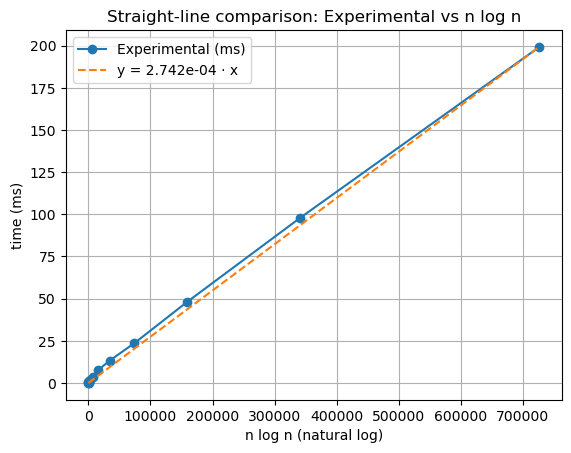

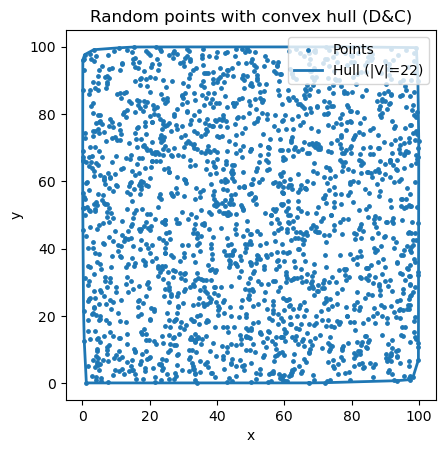

In [65]:
"""
Module: experimental_vs_theory_project2
Description: Empirically evaluate the divide-and-conquer convex hull algorithm.
             - Generate random 2D point sets.
             - Measure runtime of the D&C hull implementation.
             - Compare against theoretical O(n log n) growth (normalized n log n curve).
             - Produce plots: points-only, points+convex hull, and runtime vs theory.

@author: Juntao (Tony) Xue
@date: October 15, 2025
@version: 2.0
"""

__author__  = "Juntao (Tony) Xue"
__version__ = "2.0"
__date__    = "2025-10-15"
__project__ = "Project 2: Divide-and-Conquer Convex Hull — Experimental vs. O(n log n)"

# dnc_convex_hull.py
from typing import List, Tuple
from statistics import median
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import time
import os

Point = Tuple[float, float]

# ---------- Geometry helpers ----------
def orient(a: Point, b: Point, c: Point) -> float:
    """
    area (2x) of triangle abc = cross((b-a), (c-a)).
    cross product to determine clockwise rotation
    > 0  => a->b->c is a left turn (counterclockwise)
    < 0  => right turn (clockwise)
    == 0 => collinear
    """
    return (b[0]-a[0])*(c[1]-a[1]) - (b[1]-a[1])*(c[0]-a[0])

def next(i: int, m: int) -> int:
    """Circular 'next' index on a polygon of size m (Counterclockwise order)."""
    return (i + 1) % m

def prev(i: int, m: int) -> int:
    """Circular 'previous' index on a polygon of size m (Counterclockwise order)."""
    return (i - 1 + m) % m

def rightmost_index(H: List[Point]) -> int:
    """
    Index of the rightmost vertex in hull H.
    compare x value, if ties, then choose highest y.
    """
    mx, my, idx = H[0][0], H[0][1], 0
    for i, (x, y) in enumerate(H):
        if x > mx or (x == mx and y > my):
            mx, my, idx = x, y, i
    return idx

def leftmost_index(H: List[Point]) -> int:
    """
    Index of the leftmost vertex in hull H.
    compare x value, if ties, then choose highest y.
    """
    mnx, mny, idx = H[0][0], H[0][1], 0
    for i, (x, y) in enumerate(H):
        if x < mnx or (x == mnx and y < mny):
            mnx, mny, idx = x, y, i
    return idx

# ---------- Small hull (≤3) with tiny monotone chain ----------
def hull_of_small(S: List[Point]) -> List[Point]:
    """
    Convex hull for |S| <= 3.
    We use a mini monotone-chain pass that:
      - sorts and deduplicates points,
      - builds lower and upper chains,
      - uses <= in the orientation tests to DROP interior collinear points.
    Returns vertices in CCW order.
    """
    S = sorted(set(S))  # delete duplicate + sort by (x,y)
    if len(S) <= 1:
        return S[:]

    # Build lower chain
    L: List[Point] = []
    for p in S:
        # While last turn is not strictly left, pop the last vertex
        while len(L) >= 2 and orient(L[-2], L[-1], p) <= 0:
            L.pop()
        L.append(p)

    # Build upper chain
    U: List[Point] = []
    for p in reversed(S):
        while len(U) >= 2 and orient(U[-2], U[-1], p) <= 0:
            U.pop()
        U.append(p)

    # Concatenate without duplicating the first/last point
    return L[:-1] + U[:-1]

# ---------- Tangents  ----------
def find_upper_tangent(HL: List[Point], HR: List[Point]) -> Tuple[int, int]:
    """
    Find indices (i, j) such that the line HL[i]--HR[j] is the common UPPER tangent:
      - all vertices of HL and HR lie on or BELOW this line.
    We start from a good guess (rightmost of HL, leftmost of HR)
    and rotate the line until both sides are supporting.
    """
    i = rightmost_index(HL)
    j = leftmost_index(HR)
    mL, mR = len(HL), len(HR)

    changed = True
    while changed:
        changed = False
        # Rotate around HL clockwise while the line is not a supporting line for HL
        while orient(HR[j], HL[i], HL[prev(i, mL)]) >= 0:
            i = prev(i, mL)
            changed = True
        # Rotate around HR counterclockwise while the line is not a supporting line for HR
        while orient(HL[i], HR[j], HR[next(j, mR)]) <= 0:
            j = next(j, mR)
            changed = True
    return i, j

def find_lower_tangent(HL: List[Point], HR: List[Point]) -> Tuple[int, int]:
    """
    Find indices (i, j) such that the line HL[i]--HR[j] is the common LOWER tangent:
      - all vertices of HL and HR lie on or ABOVE this line.
    Symmetric to the upper tangent, but we rotate in the opposite directions.
    """
    i = rightmost_index(HL)
    j = leftmost_index(HR)
    mL, mR = len(HL), len(HR)

    changed = True
    while changed:
        changed = False
        # Rotate around HL counterclockwise
        while orient(HR[j], HL[i], HL[next(i, mL)]) <= 0:
            i = next(i, mL)
            changed = True
        # Rotate around HR clockwise
        while orient(HL[i], HR[j], HR[prev(j, mR)]) >= 0:
            j = prev(j, mR)
            changed = True
    return i, j

def splice(HL: List[Point], HR: List[Point],
           iu: int, ju: int, il: int, jl: int) -> List[Point]:
    """
    Splice the OUTER arcs between the tangent endpoints to form the merged hull (CCW).
      - On HR: take the CCW arc from ju to jl (inclusive).
      - On HL: take the CCW arc from il to iu (inclusive).
    Concatenate the two arcs. If the first and last vertices coincide, delete the duplicate.
    """
    mL, mR = len(HL), len(HR)

    # HR arc: ju -> jl (CCW on HR)
    R_chain: List[Point] = [HR[ju]]
    k = ju
    while k != jl:
        k = next(k, mR)
        R_chain.append(HR[k])

    # HL arc: il -> iu (CCW on HL)
    L_chain: List[Point] = [HL[il]]
    k = il
    while k != iu:
        k = next(k, mL)
        L_chain.append(HL[k])

    # Concatenate arcs to get merged CCW hull
    merged = R_chain + L_chain

    # Remove duplicate if we wrapped to the same point
    if len(merged) >= 2 and merged[0] == merged[-1]:
        merged.pop()
    return merged

def hull_rec(sorted_pts: List[Point]) -> List[Point]:
    """
    Recursive divide-and-conquer hull on points sorted by (x,y).
      - Divide: split into halves
      - Conquer: recursive hull on each half (returns CCW hulls)
      - Combine: find upper/lower tangents and splice outer arcs
    """
    n = len(sorted_pts)
    if n <= 3:  # Base case: handle with small monotone-chain
        return hull_of_small(sorted_pts)

    mid = n // 2
    HL = hull_rec(sorted_pts[:mid])   # left half hull (CCW)
    HR = hull_rec(sorted_pts[mid:])   # right half hull (CCW)

    # Merge via upper and lower tangents
    iu, ju = find_upper_tangent(HL, HR)
    il, jl = find_lower_tangent(HL, HR)
    return splice(HL, HR, iu, ju, il, jl)

def convex_hull_divide_and_conquer(P: List[Point]) -> List[Point]:
    """
    Entry point:
      - Sort and deduplicate points once (O(n log n)).
      - Recurse and merge hulls in linear time per level.
    Returns a CCW list of hull vertices with interior collinear points removed.
    """
    if not P:
        return []
    A = sorted(set(P))  # sort once + delete duplication by (x,y)
    if len(A) <= 3:
        return hull_of_small(A)
    return hull_rec(A)


# ---------- Demo with random points ----------
def make_random_points(n: int, seed: int = 12345) -> np.ndarray:
    """
    Create a mixture of distributions (uniform square, ring....)
    to test the hull visually.
    """
    rng = np.random.default_rng(seed)
    square = rng.uniform(-10, 10, size=(int(0.6*n), 2))
    theta = rng.uniform(0, 2*np.pi, size=int(0.2*n))
    radius = 9 + rng.normal(0, 0.4, size=int(0.2*n))
    ring = np.column_stack([radius*np.cos(theta), radius*np.sin(theta)])
    cluster1 = rng.normal(loc=(6, 6), scale=0.9, size=(int(0.1*n), 2))
    cluster2 = rng.normal(loc=(-7, -4), scale=1.2, size=(n - len(square) - len(ring) - len(cluster1), 2))
    return np.vstack([square, ring, cluster1, cluster2])


 # ----------------------------
# Experiment: runtime vs n log n
# ----------------------------
# Choose sizes that grow geometrically; adjust as needed.
N_VALUES = [2**k for k in range(4, 17)]

def gen_points(n: int, seed: int = 12345) -> np.ndarray:
    """Uniform random points in [0,100) x [0,100)."""
    rng = np.random.default_rng(seed + n)  # vary with n to avoid repeats
    return rng.random((n, 2)) * 100.0

def time_hull(n: int, repeats: int = 3) -> float:
    """Return runtime (milliseconds)."""
    pts = gen_points(n, seed=1000)
    pts_list = [tuple(p) for p in pts]
    t0 = time.perf_counter()
    _ = convex_hull_divide_and_conquer(pts_list)
    t1 = time.perf_counter()
    return (t1 - t0) * 1e3

def run_experiments(n_values: List[int]) -> pd.DataFrame:
    """
    For each n, record:
      - Experimental_ms: measured time (ms)
      - Theory_nlogn: n * ln(n)
    """
    rows = []
    for n in n_values:
        exp_ms = time_hull(n, repeats=3)
        theo = n * math.log(max(n, 2))  # natural log
        rows.append({"n": n, "Experimental_ms": exp_ms, "Theory_nlogn": theo})
    return pd.DataFrame(rows)

def normalize_single_point(df: pd.DataFrame) -> Tuple[pd.DataFrame, float]:
    """Scale n log n by C so it matches the largest-n experimental time."""
    idx_max = df["n"].idxmax()
    y_max = df.loc[idx_max, "Experimental_ms"]
    f_max = df.loc[idx_max, "Theory_nlogn"]
    C = y_max / f_max if f_max != 0 else 1.0
    df["Scaled_nlogn"] = C * df["Theory_nlogn"]
    return df, C

def plot_results(df: pd.DataFrame, C: float, outdir: str = ".") -> Tuple[str, str]:
    """Make two figures: (1) log–log vs n, (2) straight-line vs n log n."""
    os.makedirs(outdir, exist_ok=True)

    # Plot 1: Experimental vs scaled n log n (log–log axes)
    plt.figure()
    plt.plot(df["n"], df["Experimental_ms"], "o-", label="Experimental (ms)")
    plt.plot(df["n"], df["Scaled_nlogn"], "s-", label="Scaled n log n")
    plt.xscale("log"); plt.yscale("log")
    plt.xlabel("n"); plt.ylabel("time (ms)")
    plt.title("Convex Hull (D&C): Experimental vs n log n (log–log)")
    plt.grid(True, which="both")
    plt.legend()
    p1 = os.path.join(outdir, "hull_exp_vs_nlogn_loglog.png")
    plt.savefig(p1, bbox_inches="tight")

    # Plot 2: straight-line check — time vs n log n
    x = df["Theory_nlogn"].to_numpy()
    y = df["Experimental_ms"].to_numpy()
    x_min, x_max = float(np.min(x)), float(np.max(x))

    plt.figure()
    plt.plot(x, y, "o-", label="Experimental (ms)")
    plt.plot([x_min, x_max], [C * x_min, C * x_max], "--", label=f"y = {C:.3e} · x")
    plt.xlabel("n log n (natural log)")
    plt.ylabel("time (ms)")
    plt.title("Straight-line comparison: Experimental vs n log n")
    plt.grid(True)
    plt.legend()
    p2 = os.path.join(outdir, "hull_straight_line.png")
    plt.savefig(p2, bbox_inches="tight")

    return p1, p2

# ----------------------------
# Optional: quick visual sanity check (points + hull)
# ----------------------------
def plot_points_and_hull(n: int = 2000, seed: int = 42, outdir: str = ".") -> str:
    """Saves a figure with random points and the computed hull overlay."""
    pts = gen_points(n, seed=seed)
    hull_list = convex_hull_divide_and_conquer([tuple(p) for p in pts])
    if len(hull_list) >= 1:
        hull_arr = np.array(hull_list + [hull_list[0]])
    else:
        hull_arr = np.empty((0, 2))
    plt.figure()
    plt.scatter(pts[:, 0], pts[:, 1], s=6, label="Points")
    if len(hull_arr) >= 2:
        plt.plot(hull_arr[:, 0], hull_arr[:, 1], linewidth=2, label=f"Hull (|V|={len(hull_list)})")
    plt.gca().set_aspect("equal", adjustable="box")
    plt.xlabel("x"); plt.ylabel("y")
    plt.title("Random points with convex hull (D&C)")
    plt.legend()
    p = os.path.join(outdir, "hull_points_overlay.png")
    plt.savefig(p, bbox_inches="tight")
    return p

# ----------------------------
# Main
# ----------------------------
def main():
    outdir = "."
    df = run_experiments(N_VALUES)
    df, C = normalize_single_point(df)

    # Save CSV
    csv_path = os.path.join(outdir, "hull_runtime_vs_nlogn.csv")
    df.to_csv(csv_path, index=False)

    # Plots
    p1, p2 = plot_results(df, C, outdir=outdir)

    # Optional: one visual hull sanity check
    p3 = plot_points_and_hull(n=2000, seed=123, outdir=outdir)

    # Console summary
    print(df.to_string(index=False))
    print(f"\nNormalization constant C (matches largest n): {C:.6e}")
    print(f"Saved: {csv_path}")
    print(f"Saved: {p1}")
    print(f"Saved: {p2}")
    print(f"Saved: {p3}")

if __name__ == "__main__":
    main()

